In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from collections import OrderedDict
from datetime import datetime, timedelta
import time
import math
import random
from pprint import pprint

from joblib import dump, load
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

from tqdm import tqdm

# Get All Pairs of Input/Results Files

In [2]:
def find_file_pairs(input_path, results_path):
    '''
        Find matching input/output files
        
        Args:
            input_path (string): relative path to input files
            results_path (string): relative path to results files
            
        Returns:
            (list) list of (input_file,results_file) pairs
    '''
    
    # Get a list of all input files and results files
    input_files = [input_path + file for file in os.listdir(input_path) if file.endswith(".DRF")]
    results_files = [results_path + file for file in os.listdir(results_path) if file.endswith('.2')]
    
    # Get names of files w/o directories/extensions
    input_names = sorted([file[len(input_path) : -4] for file in input_files])
    results_names = sorted([file[len(results_path) : -2] for file in results_files])
    
    # Find matches 
    matches = [name for name in input_names if name in results_names]
    
    # Create list of input/results file pairs -- [(input_file, results_file),(...),...]
    file_pairs = [('{}{}.DRF'.format(input_path, name), '{}{}.2'.format(results_path, name)) for name in matches]
    
    return file_pairs

file_pairs = find_file_pairs(input_path='./input_files/', results_path='./results_files/')
print(len(file_pairs))

402


# Parse Input and Results Files for Relevant Fields
These fields do not include past performance data -- these past performance fields will be handled by a separate process.

In [3]:
# Maps for input/results file structures -- colnum:colname
input_map = OrderedDict({
        1: 'date',
        2: 'race_num',
        3: 'post_pos',
        1435: 'num_entrants',
        44: 'horse_name',
        855: 'last_speed_rating',
        216: 'speed_par',
        33: 'app_weight_alw',
        64: 'starts_at_dist',
        96: 'lt_starts',
        100: 'lt_earnings',
        43: 'ml_odds',
        28: 'trainer_starts',
        29: 'trainer_wins',
        34: 'jockey_starts',
        35: 'jockey_wins'
    })

results_map = OrderedDict({
    1: 'date',
    2: 'race_num',
    4: 'horse_name',
    59: 'finish_pos', 
})

In [4]:
input_df = pd.DataFrame()
results_df = pd.DataFrame()

for pair in file_pairs:
    #Get input/results file names
    input_file = pair[0]
    results_file = pair[1]
    
    # Open files to dataframe -- Take only columns that are necessary
    input_cols = [k for k in input_map.keys()]
    results_cols = [k for k in results_map.keys()]
    input_tmp = pd.read_csv(input_file, header=None)[input_cols]
    results_tmp = pd.read_csv(results_file, header=None)[results_cols]
    
    # Rename cols
    input_tmp.columns = [input_map[col] for col in input_tmp.columns]
    results_tmp.columns = [results_map[col] for col in results_tmp.columns]
    
    # Add track code
    track_code = input_file[-15:-12]
    input_tmp['track_code'] = track_code
    results_tmp['track_code'] = track_code
    
    # Add these inputs/results to dataframes
    input_df = input_df.append(input_tmp)
    results_df = results_df.append(results_tmp)
    
# Merge input and results dfs together -- convert horse_name to upper for results
results_df['horse_name'] = results_df['horse_name'].apply(lambda x: str(x).upper())
master_df = pd.merge(input_df, results_df,
                     how='left', left_on=['date', 'race_num', 'track_code', 'horse_name'],
                     right_on=['date','race_num', 'track_code', 'horse_name'])
master_df.head()

,starts_at_dist,date,race_num,post_pos,lt_earnings,app_weight_alw,lt_starts,ml_odds,horse_name,jockey_starts,jockey_wins,last_speed_rating,speed_par,num_entrants,trainer_starts,trainer_wins,track_code,finish_pos
0,24,20180506,1,1,31833,NaN,24,3.0,ITZ ALL GOOD,0,0,98.0,NaN,5.0,0,0,AJX,1.0
1,15,20180506,1,2,22706,NaN,15,1.6,STEEL PATRIOT,0,0,96.0,NaN,5.0,0,0,AJX,4.0
2,29,20180506,1,3,37294,NaN,29,2.5,DM AURORA,0,0,92.0,NaN,5.0,0,0,AJX,2.0
3,16,20180506,1,4,39885,NaN,16,4.5,ROUGE RIVER CARTEL,0,0,94.0,NaN,5.0,0,0,AJX,5.0
4,32,20180506,1,5,134484,NaN,32,2.0,RECKLESS AN WILD,0,0,97.0,NaN,5.0,0,0,AJX,3.0


In [5]:
def get_jockey_win_pct(df):
    df['jockey_win_pct'] = df['jockey_wins'] / df['jockey_starts']
    return df.drop(['jockey_wins', 'jockey_starts'], axis=1)

def get_trainer_win_pct(df):
    df['trainer_win_pct'] = df['trainer_wins'] / df['trainer_starts']
    return df.drop(['trainer_wins', 'trainer_starts'], axis=1)

def get_in_the_money(df):
    df['in_the_money'] = df['finish_pos'] <= 3.0
    return df


# Calculate jockey/trainer win percentages
master_df = get_jockey_win_pct(master_df)
master_df = get_trainer_win_pct(master_df)

# Determine if horse was in the money
master_df = get_in_the_money(master_df)

# Clean NaN cols
master_df = master_df.fillna(value=0)
master_df.head()

,starts_at_dist,date,race_num,post_pos,lt_earnings,app_weight_alw,lt_starts,ml_odds,horse_name,last_speed_rating,speed_par,num_entrants,track_code,finish_pos,jockey_win_pct,trainer_win_pct,in_the_money
0,24,20180506,1,1,31833,0.0,24,3.0,ITZ ALL GOOD,98.0,0.0,5.0,AJX,1.0,0.0,0.0,True
1,15,20180506,1,2,22706,0.0,15,1.6,STEEL PATRIOT,96.0,0.0,5.0,AJX,4.0,0.0,0.0,False
2,29,20180506,1,3,37294,0.0,29,2.5,DM AURORA,92.0,0.0,5.0,AJX,2.0,0.0,0.0,True
3,16,20180506,1,4,39885,0.0,16,4.5,ROUGE RIVER CARTEL,94.0,0.0,5.0,AJX,5.0,0.0,0.0,False
4,32,20180506,1,5,134484,0.0,32,2.0,RECKLESS AN WILD,97.0,0.0,5.0,AJX,3.0,0.0,0.0,True


# Get Past Performance Data

In [6]:
# Map for past performance fields
input_keys = OrderedDict({
    1: 'date',
    2: 'race_num',
    44: 'horse_name',
})

input_pp_map = OrderedDict({
    615 : 'pp_finish_pos',
    345 : 'pp_num_entrants',
    5: 'todays_distance',
    315: 'pp_distance',
    #535 : 'pp_race_class',
    255 : 'pp_race_date',
    1045: 'pp_claimed',
    1125: 'pp_favorite',
    605: 'pp_stretch_pos',
    113: 'pp_workout_time',
    465: 'pp_winners_margin'
})

#name_to_pp_col = OrderedDict({v:k for k,v in input_pp_map.items()})

In [7]:
def get_past_performance_data(input_files, num_races=3):
    '''
        Go through input files and get past performance data
        
        Args: 
            input_files (list): list of input file names 
            num_races (int): number of races back to grab data for
            
        Returns:
            pd.DataFrame with past performance data for each horse
    '''
    pp_df = pd.DataFrame()
    
    # Create new mapping for this number of races
    updated_pp_map = OrderedDict({k+race:'{}_{}'.format(v, race) for k,v in input_pp_map.items() for race in range(num_races)})
    
    for file in input_files:
        # Open input file to df
        df = pd.read_csv(file, header=None)
        
        # Only include key/past performance columns
        incl_cols = list(input_keys.keys()) + list(updated_pp_map.keys())
        df = df[incl_cols]
        
        # Rename columns
        renamed_cols = []
        for col in df.columns:
            try:
                # PP Column
                rn_col = updated_pp_map[col]
            except:
                # Key Column 
                rn_col = input_keys[col]    
            renamed_cols.append(rn_col)
        df.columns = renamed_cols
        
        # Append this file's df to pp_df
        pp_df = pp_df.append(df)
    
    return pp_df

input_files = [pair[0] for pair in file_pairs]
num_races = 3
pp_df = get_past_performance_data(input_files, num_races)
pp_df.head()

,date,race_num,horse_name,pp_race_date_1,pp_race_date_2,todays_distance_0,todays_distance_1,todays_distance_2,pp_winners_margin_0,pp_winners_margin_1,...,pp_finish_pos_1,pp_finish_pos_2,pp_favorite_2,pp_workout_time_0,pp_workout_time_1,pp_workout_time_2,pp_distance_0,pp_distance_1,pp_distance_2,pp_race_date_0
0,20180506,1,ITZ ALL GOOD,20171016.0,20171002.0,300,D,NaN,0.75,0.25,...,2,4,0.0,13.2,13.6,13.2,220.0,300.0,350.0,20171030.0
1,20180506,1,STEEL PATRIOT,20171009.0,20170911.0,300,D,NaN,0.25,0.25,...,7,1,0.0,13.8,13.2,12.0,400.0,440.0,330.0,20171030.0
2,20180506,1,DM AURORA,20171009.0,20170925.0,300,D,NaN,0.75,0.13,...,4,6,0.0,12.6,12.4,-13.2,350.0,350.0,300.0,20171023.0
3,20180506,1,ROUGE RIVER CARTEL,20171002.0,20170918.0,300,D,NaN,0.25,0.50,...,5,3,0.0,13.4,-12.2,13.2,400.0,350.0,330.0,20171030.0
4,20180506,1,RECKLESS AN WILD,20170720.0,20161017.0,300,D,NaN,0.50,0.50,...,1,4,0.0,12.6,13.4,13.2,350.0,330.0,350.0,20170810.0


# Clean Past Performance DataFrame

In [8]:
def clean_finish_pos_cols(pp_df, num_races=3):
        # Get finish position column names
        finish_pos_cols = ['pp_finish_pos_{}'.format(race) for race in range(num_races)]
        
        def clean_val(val):
            # If value is numeric, return its integer rep
            try:
                return int(val)
            except:
                # If value not numeric, return 0 (did not finish)
                return int(92)
            
        # Clean columns
        for col in finish_pos_cols:
            pp_df[col] = pp_df[col].apply(clean_val)
            
        return pp_df
    
def clean_stretch_pos_cols(pp_df, num_races=3):
        # Get stretch position column names
        stretch_pos_cols = ['pp_stretch_pos_{}'.format(race) for race in range(num_races)]
        
        def clean_val(val):
            # If value is numeric, return its integer rep
            try:
                return int(val)
            except:
                # If value not numeric, return 92 (did not finish)
                return int(92)
            
        
        # Clean columns
        for col in stretch_pos_cols:
            pp_df[col] = pp_df[col].apply(clean_val)
            
        return pp_df
    
def clean_favorite_cols(pp_df, num_races=3):
    def conv(val):
        if math.isnan(val):
            return int(0)
        else:
            return int(val)
        
    # Get favorite column names
    favorite_columns = ['pp_favorite_{}'.format(race) for race in range(num_races)]
    
    # Convert to integers
    for col in favorite_columns:
        pp_df[col] = pp_df[col].apply(conv)
        
    return pp_df
    
    
def clean_pp_df(pp_df, num_races=3):
    '''
        Clean fields in pp_df
        
        Args:
            pp_df (pd.DataFrame): dataframe to clean
            
        Returns:
            (pd.DataFrame) cleaned version of pp_df
    '''
    pp_df = clean_finish_pos_cols(pp_df, num_races)
    pp_df = clean_stretch_pos_cols(pp_df, num_races)
    pp_df = clean_favorite_cols(pp_df, num_races)
    
    return pp_df

pp_df = clean_pp_df(pp_df, num_races)
pp_df.head(10)

,date,race_num,horse_name,pp_race_date_1,pp_race_date_2,todays_distance_0,todays_distance_1,todays_distance_2,pp_winners_margin_0,pp_winners_margin_1,...,pp_finish_pos_1,pp_finish_pos_2,pp_favorite_2,pp_workout_time_0,pp_workout_time_1,pp_workout_time_2,pp_distance_0,pp_distance_1,pp_distance_2,pp_race_date_0
0,20180506,1,ITZ ALL GOOD,20171016.0,20171002.0,300,D,NaN,0.75,0.25,...,2,4,0,13.2,13.6,13.2,220.0,300.0,350.0,20171030.0
1,20180506,1,STEEL PATRIOT,20171009.0,20170911.0,300,D,NaN,0.25,0.25,...,7,1,0,13.8,13.2,12.0,400.0,440.0,330.0,20171030.0
2,20180506,1,DM AURORA,20171009.0,20170925.0,300,D,NaN,0.75,0.13,...,4,6,0,12.6,12.4,-13.2,350.0,350.0,300.0,20171023.0
3,20180506,1,ROUGE RIVER CARTEL,20171002.0,20170918.0,300,D,NaN,0.25,0.50,...,5,3,0,13.4,-12.2,13.2,400.0,350.0,330.0,20171030.0
4,20180506,1,RECKLESS AN WILD,20170720.0,20161017.0,300,D,NaN,0.50,0.50,...,1,4,0,12.6,13.4,13.2,350.0,330.0,350.0,20170810.0
5,20180506,2,TOO MUCH WHITE,20170918.0,20170813.0,220,D,NaN,0.13,0.50,...,92,1,0,12.2,14.0,13.8,350.0,400.0,330.0,20171023.0
6,20180506,2,JESS RIP,20171002.0,20170903.0,220,D,NaN,2.00,0.13,...,5,5,0,-12.2,12.4,13.6,350.0,250.0,300.0,20171030.0
7,20180506,2,JUNOIMZOOMIN,20170723.0,NaN,220,D,NaN,0.50,1.25,...,1,92,0,13.8,15.2,13.6,330.0,330.0,NaN,20170813.0
8,20180506,2,FLIRT WITH THE BOYZ,20170918.0,20170827.0,220,D,NaN,0.13,0.25,...,7,4,0,13.2,12.6,-13.4,250.0,350.0,300.0,20171030.0
9,20180506,2,GEORGIES MAY KITTY,20171016.0,20171002.0,220,D,NaN,2.00,0.06,...,2,3,0,13.6,12.8,14.0,350.0,400.0,250.0,20171030.0


# Derive Past Performance Metrics

In [9]:
def get_improved_finish_pos(pp_df, num_races=3):
    '''
        Calculate if horse is improving its finish position over the past races
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            
        Returns:
            (pd.DataFrame) an updated version of pp_df with a column for improved
            finish position
    '''
    
    def all_seq_vals_less_than_one(seq):
        ''' Returns true if all values in the passed sequence are <=1 '''
        for elt in seq:
            if elt > 1:
                return False
        return True

    # Get past finish pos cols
    finish_pos_cols = ['pp_finish_pos_{}'.format(race) for race in range(num_races)]
    # Concat all finish positions for each horse in a sequential list starting with most
    # recent race 
    finish_pos_seqs = pp_df[finish_pos_cols].values.tolist()
    
    imp_finish_pos = []
    for seq in finish_pos_seqs:
        # Skip any sequence where NaN appears
        if np.nan in seq:
            imp_finish_pos.append(False)
        # Skip any seq where horse didn't finish (fractional finish pos > 1)
        elif not all_seq_vals_less_than_one(seq):
            imp_finish_pos.append(False)
        else:
            # Determine if last finish was better than previous average finish
            most_recent = seq[0]
            avg_prev_finish = np.mean(seq[1:])
            imp_finish_pos.append(most_recent < avg_prev_finish)
            
    # Assign improved finish position series to pp_df
    pp_df['imp_finish_pos'] = pd.Series(imp_finish_pos)
    
    return pp_df

def get_recent_race(pp_df, threshold=21):
    '''
        Determine if a horse has had a previous race within threshold days
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            threshold (int): days to look back
            
        Returns:
            (pd.DataFrame) updated pp_df containing bool column stating whether
            each horse had a recent race or not
    '''
    
    def conv_date(val):
        # Set NaNs to 1970
        if math.isnan(float(val)):
            val = 19700101
        val = str(int(val))
        return datetime.strptime(val, '%Y%m%d')
    
    # Determine if race most recent race is within threshold
    pp_df['today'] = pp_df['date'].apply(conv_date)
    pp_df['last_race'] = pp_df['pp_race_date_0'].apply(conv_date)
    pp_df['timedelta'] = pd.Series(timedelta(days=threshold), index=pp_df.index)
    pp_df['cutoff'] = pp_df['today'] - pp_df['timedelta']
    pp_df['recent_race'] = pp_df['cutoff'] <= pp_df['last_race'] # Cutoff happened before last race
    
    # Drop intermediate columns
    drop_cols = ['today', 'last_race', 'timedelta', 'cutoff']
    return pp_df.drop(drop_cols, axis=1)
    
def get_past_finish_pos(pp_df, num_races=3):
    '''
        Calculate previous finish positions as finish_pos/num_entrants
        
        Args:
            pp_df (pd.DataFrame) past performance dataframe
            num_races (int): number of races for which we have past performance
        
        Returns:
            (pd.DataFrame) updated pp_df with finish positions calculated
    '''
    # Get finish position/entrants columns names
    finish_pos_cols = ['pp_finish_pos_{}'.format(race) for race in range(num_races)]
    entrants_cols = ['pp_num_entrants_{}'.format(race) for race in range(num_races)]
    cols = list(zip(finish_pos_cols, entrants_cols))
    
    # Divide finish pos by num entrants, save a raw copy of finish position
    for f_col, e_col in cols:
        pp_df['raw_'+f_col] = pp_df[f_col]
        pp_df[f_col] = pp_df[f_col] / pp_df[e_col]
    
    return pp_df

def get_claimed_in_past(pp_df, num_races=3):
    '''
        Determine if a horse was claimed in the past num_races
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
            
        Returns:
            (pd.DataFrame) updated version of pp_df
    '''
    # Claimed column names
    claimed_cols = ['pp_claimed_{}'.format(race) for race in range(num_races)]
    claimed_seqs = pp_df[claimed_cols].values.tolist()
    
    # Determine if claimed in recent races    
    claimed = [True if 'c' in seq else False for seq in claimed_seqs]
    
    # Assign to pp_df
    pp_df['was_claimed'] = pd.Series(claimed, index=pp_df.index)
    
    return pp_df

def was_favorite(pp_df, num_races=3):
    '''
        Determine if a horse was the favorite in any of its recent races
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
    '''
    # Get favorite columns
    favorite_cols = ['pp_favorite_{}'.format(race) for race in range(num_races)]
    favorite_seqs = pp_df[favorite_cols].values.tolist()
    
    # If 1 in sequence, horse was favorite in recent race
    was_favorite = [True if 1 in seq else False for seq in favorite_seqs]
    
    pp_df['was_favorite'] = pd.Series(was_favorite, index=pp_df.index)
    
    return pp_df

def improved_stretch_pos(pp_df, num_races=3):
    '''
        Determine if a horse improved its finish position down the stretch in the most
        recent race
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
    '''
    # Stretch position columns
    stretch_pos_cols = ['pp_stretch_pos_{}'.format(race) for race in range(num_races)]
    
    # Get fractional stretch position
    pp_df['pp_stretch_pos'] = pp_df['pp_stretch_pos_0'] / pp_df['pp_num_entrants_0']
    
    # Determine if stretch pos > finish pos
    pp_df['improved_stretch_pos'] = pp_df['pp_stretch_pos'] > pp_df['pp_finish_pos_0']
    
    return pp_df.drop(['pp_stretch_pos'], axis=1)

def had_bullet_workout(pp_df, num_races=3):
    '''
        Determine if a horse had a bullet workout in previous workout
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
    '''
    # Get workout time columns
    workout_cols = ['pp_workout_time_{}'.format(race) for race in range(num_races)]
    
    # Determine if last workout was bullet
    pp_df['had_bullet'] = pp_df['pp_workout_time_0'] < 0
    
    return pp_df

def won_by_margin(pp_df, num_races=3, margin=5):
    '''
        Determine if a horse won last race by at least margin lengths
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
            margin (float): number of lengths by which horse had to win
            
        Returns:
            (pd.DataFrame) updated version of pp_df
    '''
    # Find all winners of last race
    winners = pp_df.loc[pp_df.raw_pp_finish_pos_0 == 1]
    
    # Find all winners with at least margin length victory
    big_winners = winners.loc[winners.pp_winners_margin_0 >= margin].index
    
    # Create new col, default to false. Set True for all horses in big_winners index
    pp_df['won_by_margin'] = pd.Series(False, index=pp_df.index)
    pp_df.loc[big_winners, 'won_by_margin'] = True
    
    return pp_df

def won_at_similar_distance(pp_df, num_races=3):
    '''
        Determine if a horse won a recent race at the same distance as today's race
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
            
        Returns:
            (pd.DataFrame) updated version of pp_df
    '''
    # Get distance and finish pos cols
    distance_cols = ['pp_distance_{}'.format(race) for race in range(num_races)]
    raw_finish_cols = ['raw_pp_finish_pos_{}'.format(race) for race in range(num_races)]
    
    # Find winners at similar distance by iterating through each recent race
    winners = []
    for race in range(num_races):
        dist_col = 'pp_distance_{}'.format(race)
        finish_col = 'raw_pp_finish_pos_{}'.format(race)
        today_dist_col = 'todays_distance_0'
        
        winners += pp_df.loc[(pp_df[dist_col] == pp_df[today_dist_col]) & (pp_df[finish_col] == 1)].index.tolist()
        
    # Create new column to denote if won at similar distance -- default False, True for 
    # horses in winners
    pp_df['won_at_similar_dist'] = pd.Series(False, index=pp_df.index)
    pp_df.loc[winners, 'won_at_similar_dist'] = True

    return pp_df
    
def derive_pp_metrics(pp_df, num_races=3):
    # Past Finish Positions
    pp_df = get_past_finish_pos(pp_df, num_races)
    # Improved Finish Position
    pp_df = get_improved_finish_pos(pp_df, num_races)
    # Recent race
    pp_df = get_recent_race(pp_df, 21)
    # Claimed in Past
    pp_df = get_claimed_in_past(pp_df, num_races)
    # Favorite in past
    pp_df = was_favorite(pp_df, num_races)
    # Improved stretch pos
    pp_df = improved_stretch_pos(pp_df, num_races)
    # Workout Rating
    pp_df = had_bullet_workout(pp_df, num_races)
    # Won last race by 5+ lengths
    pp_df = won_by_margin(pp_df, num_races, margin=4)
    # Won at similar distance
    pp_df = won_at_similar_distance(pp_df, num_races)    
    
    return pp_df
    
pp_df = derive_pp_metrics(pp_df)
pp_df.head()

,date,race_num,horse_name,pp_race_date_1,pp_race_date_2,todays_distance_0,todays_distance_1,todays_distance_2,pp_winners_margin_0,pp_winners_margin_1,...,raw_pp_finish_pos_1,raw_pp_finish_pos_2,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist
0,20180506,1,ITZ ALL GOOD,20171016.0,20171002.0,300,D,NaN,0.75,0.25,...,2,4,True,False,False,False,False,False,True,True
1,20180506,1,STEEL PATRIOT,20171009.0,20170911.0,300,D,NaN,0.25,0.25,...,7,1,True,False,False,True,False,False,True,True
2,20180506,1,DM AURORA,20171009.0,20170925.0,300,D,NaN,0.75,0.13,...,4,6,False,False,False,False,False,False,True,True
3,20180506,1,ROUGE RIVER CARTEL,20171002.0,20170918.0,300,D,NaN,0.25,0.50,...,5,3,False,False,False,False,False,False,True,True
4,20180506,1,RECKLESS AN WILD,20170720.0,20161017.0,300,D,NaN,0.50,0.50,...,1,4,True,False,False,True,True,False,True,True


# Clean Intermediate Derivation Columns

In [10]:
def clean_deriv_columns(pp_df, num_races=3):
    '''
        Drop all columns used as intermediates during feature derivation from pp_df
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
            
        Returns:
            (pd.DataFrame): a cleaned version of pp_df
    '''
    column_dict = {
        'claimed_cols' : ['pp_claimed_{}'.format(race) for race in range(num_races)],
        'date_cols' : ['pp_race_date_{}'.format(race) for race in range(num_races)],
        'distance_cols' : ['pp_distance_{}'.format(race) for race in range(num_races)],
        'entrants_cols' : ['pp_num_entrants_{}'.format(race) for race in range(num_races)],   
        'favorite_cols' : ['pp_favorite_{}'.format(race) for race in range(num_races)],
        'finish_pos_cols' : ['pp_finish_pos_{}'.format(race) for race in range(num_races)],
        'margin_cols' : ['pp_winners_margin_{}'.format(race) for race in range(num_races)],
        'raw_finish_cols' : ['raw_pp_finish_pos_{}'.format(race) for race in range(num_races)],
        'stretch_pos_cols' : ['pp_stretch_pos_{}'.format(race) for race in range(num_races)],
        'todays_distance_cols' : ['todays_distance_{}'.format(race) for race in range(num_races)],
        'workout_cols' : ['pp_workout_time_{}'.format(race) for race in range(num_races)],
    }
    
    for k, cols in column_dict.items():
        pp_df = pp_df.drop(cols, axis=1)
        
    return pp_df

pp_df = clean_deriv_columns(pp_df, num_races)
pp_df.head()

,date,race_num,horse_name,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist
0,20180506,1,ITZ ALL GOOD,True,False,False,False,False,False,True,True
1,20180506,1,STEEL PATRIOT,True,False,False,True,False,False,True,True
2,20180506,1,DM AURORA,False,False,False,False,False,False,True,True
3,20180506,1,ROUGE RIVER CARTEL,False,False,False,False,False,False,True,True
4,20180506,1,RECKLESS AN WILD,True,False,False,True,True,False,True,True


# Merge Past Performance with Master DF

In [11]:
master_df = pd.merge(master_df, pp_df,
                     how='left', left_on=['date', 'race_num', 'horse_name'],
                     right_on=['date','race_num', 'horse_name'])
master_df.head()

,starts_at_dist,date,race_num,post_pos,lt_earnings,app_weight_alw,lt_starts,ml_odds,horse_name,last_speed_rating,...,trainer_win_pct,in_the_money,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist
0,24,20180506,1,1,31833,0.0,24,3.0,ITZ ALL GOOD,98.0,...,0.0,True,True,False,False,False,False,False,True,True
1,15,20180506,1,2,22706,0.0,15,1.6,STEEL PATRIOT,96.0,...,0.0,False,True,False,False,True,False,False,True,True
2,29,20180506,1,3,37294,0.0,29,2.5,DM AURORA,92.0,...,0.0,True,False,False,False,False,False,False,True,True
3,16,20180506,1,4,39885,0.0,16,4.5,ROUGE RIVER CARTEL,94.0,...,0.0,False,False,False,False,False,False,False,True,True
4,32,20180506,1,5,134484,0.0,32,2.0,RECKLESS AN WILD,97.0,...,0.0,True,True,False,False,True,True,False,True,True


# Add Label 

In [12]:
def add_label(master_df):
    master_df['label'] = master_df['finish_pos'] == 1
    master_df['label'] = master_df['label'].apply(lambda x: int(x))
    return master_df.drop(['in_the_money'], axis=1)

# Apply label
master_df = add_label(master_df)
master_df.head(10)

,starts_at_dist,date,race_num,post_pos,lt_earnings,app_weight_alw,lt_starts,ml_odds,horse_name,last_speed_rating,...,trainer_win_pct,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist,label
0,24,20180506,1,1,31833,0.0,24,3.0,ITZ ALL GOOD,98.0,...,0.0,True,False,False,False,False,False,True,True,1
1,15,20180506,1,2,22706,0.0,15,1.6,STEEL PATRIOT,96.0,...,0.0,True,False,False,True,False,False,True,True,0
2,29,20180506,1,3,37294,0.0,29,2.5,DM AURORA,92.0,...,0.0,False,False,False,False,False,False,True,True,0
3,16,20180506,1,4,39885,0.0,16,4.5,ROUGE RIVER CARTEL,94.0,...,0.0,False,False,False,False,False,False,True,True,0
4,32,20180506,1,5,134484,0.0,32,2.0,RECKLESS AN WILD,97.0,...,0.0,True,False,False,True,True,False,True,True,0
5,5,20180506,2,1,28496,0.0,5,2.5,TOO MUCH WHITE,94.0,...,0.0,False,False,False,False,False,False,True,True,0
6,7,20180506,2,2,8292,0.0,7,3.5,JESS RIP,94.0,...,0.0,True,False,False,True,False,True,True,True,1
7,2,20180506,2,3,14749,0.0,2,3.0,JUNOIMZOOMIN,95.0,...,0.0,False,False,False,True,False,False,True,True,0
8,9,20180506,2,4,13662,0.0,9,5.0,FLIRT WITH THE BOYZ,97.0,...,0.0,True,False,False,False,False,False,True,True,0
9,15,20180506,2,5,22840,0.0,15,10.0,GEORGIES MAY KITTY,94.0,...,0.0,True,False,False,False,True,False,True,True,0


In [13]:
'''
# Average Horses per Race
from pprint import pprint
num_races = len(pd.Series(master_df['date'].apply(lambda x: str(x)) +\
                      master_df['race_num'].apply(lambda x: str(x)) +\
                      master_df['track_code']).unique())
num_horses = len(master_df)

print(num_horses/num_races)
'''

"\n# Average Horses per Race\nfrom pprint import pprint\nnum_races = len(pd.Series(master_df['date'].apply(lambda x: str(x)) +                      master_df['race_num'].apply(lambda x: str(x)) +                      master_df['track_code']).unique())\nnum_horses = len(master_df)\n\nprint(num_horses/num_races)\n"

# Drop Columns Unused in Training

In [16]:
unused_cols = ['date', 'race_num', 'horse_name', 'finish_pos', 'track_code', 'ml_odds']
master_df = master_df.drop(unused_cols, axis=1)
master_df.head()

,starts_at_dist,post_pos,lt_earnings,app_weight_alw,lt_starts,last_speed_rating,speed_par,num_entrants,jockey_win_pct,trainer_win_pct,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist,label
0,24,1,31833,0.0,24,98.0,0.0,5.0,0.0,0.0,True,False,False,False,False,False,True,True,1
1,15,2,22706,0.0,15,96.0,0.0,5.0,0.0,0.0,True,False,False,True,False,False,True,True,0
2,29,3,37294,0.0,29,92.0,0.0,5.0,0.0,0.0,False,False,False,False,False,False,True,True,0
3,16,4,39885,0.0,16,94.0,0.0,5.0,0.0,0.0,False,False,False,False,False,False,True,True,0
4,32,5,134484,0.0,32,97.0,0.0,5.0,0.0,0.0,True,False,False,True,True,False,True,True,0


# Convert Boolean Columns to Binary

In [18]:
bool_cols = ['imp_finish_pos', 'recent_race', 'was_claimed','was_favorite', \
             'improved_stretch_pos', 'had_bullet', 'won_by_margin', \
             'won_at_similar_dist']

for col in bool_cols:
    master_df[col] = master_df[col].apply(lambda x: int(x))

master_df.head()

,starts_at_dist,post_pos,lt_earnings,app_weight_alw,lt_starts,last_speed_rating,speed_par,num_entrants,jockey_win_pct,trainer_win_pct,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist,label
0,24,1,31833,0.0,24,98.0,0.0,5.0,0.0,0.0,1,0,0,0,0,0,1,1,1
1,15,2,22706,0.0,15,96.0,0.0,5.0,0.0,0.0,1,0,0,1,0,0,1,1,0
2,29,3,37294,0.0,29,92.0,0.0,5.0,0.0,0.0,0,0,0,0,0,0,1,1,0
3,16,4,39885,0.0,16,94.0,0.0,5.0,0.0,0.0,0,0,0,0,0,0,1,1,0
4,32,5,134484,0.0,32,97.0,0.0,5.0,0.0,0.0,1,0,0,1,1,0,1,1,0


# Create Test/Dev/Train Splits for ITM Model

In [19]:
from sklearn.model_selection import train_test_split

# Split out training data
train_data, int_data, train_labels, int_labels = train_test_split(
                                    master_df.drop(['label'], axis=1),
                                    master_df['label'],
                                    test_size=0.3)

# Split out into dev and testing data
test_data, dev_data, test_labels, dev_labels = train_test_split(
                                    int_data,
                                    int_labels,
                                    test_size = 0.5)

print((len(train_data), len(train_labels)), (len(test_data), len(test_labels)), (len(dev_data), len(dev_labels)))

(21695, 21695) (4649, 4649) (4649, 4649)


# Ensure Each Class is Equally Represented

In [20]:

def evenly_distribute(data, labels):
    # Get Idx values of pos/negative labels
    pos_idx = labels[labels==1].index
    neg_idx = labels[labels==0].index
    # Count number of pos/neg samples
    pos_count = len(pos_idx)    
    # Randomly sample as many negative as positive
    neg_keep_idx = random.sample(list(neg_idx), pos_count)
    # Combine pos/neg_keep indices
    keep_idx = pos_idx.union(neg_keep_idx)
    
    return data.loc[keep_idx], labels.loc[keep_idx]
    
train_data, train_labels = evenly_distribute(train_data, train_labels)
test_data, test_labels = evenly_distribute(test_data, test_labels)
dev_data, dev_labels = evenly_distribute(dev_data, dev_labels)

print('Training: {}'.format(len(train_data)))
print('Testing: {}'.format(len(test_data)))
print('Dev: {}'.format(len(dev_data)))


Training: 4962
Testing: 1024
Dev: 1130


# Standardize WIN Test/Dev/Training Sets

In [21]:
def standardize_series(s):
    return (s - s.mean()) / s.std()

# Standardize training data
for col in train_data.columns:
    if col != 'label':
        train_data.loc[:,col] = standardize_series(train_data[col])

# Standardize testing data
for col in test_data.columns:
    if col != 'label':
        test_data.loc[:, col] = standardize_series(test_data[col])
        
# Standardize dev data
for col in dev_data.columns:
    if col != 'label':
        dev_data.loc[:, col] = standardize_series(dev_data[col])

# Define/Train WIN Model
Train the model that predicts whether or not a horse will finish win the race (not taking into account other horses in the race)

In [23]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

clf = GradientBoostingClassifier(n_estimators=1000, max_leaf_nodes=4,
                                 min_samples_split=2, learning_rate=0.01)

#scores = cross_val_score(clf, dev_data, dev_labels, cv=5, n_jobs=-1)
scores = cross_val_score(clf, train_data, train_labels, cv=5, n_jobs=-1)
print(scores.mean(), scores)

0.6116436522359965 [0.62374245 0.625      0.59375    0.61491935 0.60080645]


In [24]:
clf.fit(train_data, train_labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=4,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [27]:
samples = 1000

preds = []
labels = []
conf = []

for elt in range(samples):
    # Pick random sample from testing data
    idx = random.choice(seq=test_data.index)
    sample = test_data.loc[idx]
    label = test_labels[idx]
    
    # Predict using clf
    probs = clf.predict_proba(sample.values.reshape(1,-1))[0]
    if probs[0] >= probs[1]:
        preds.append(0)
    else: 
        preds.append(1)
    labels.append(int(label))
    conf.append(probs)

# Check results
diff = np.abs(pd.Series(preds) - pd.Series(labels))
res = np.sum(diff) / samples

print('Accuracy: {}'.format(1 - res))

# Check confidence when right/wrong
right = []
wrong = []
for ii in range(len(preds)):
    # Get average confidence level when we are right
    if preds[ii] == labels[ii]:
        right.append(conf[ii][preds[ii]])
    else:
        wrong.append(conf[ii][preds[ii]])
        
print('Average Conf when Right: {}'.format(np.mean(right)))
print('Average Conf when Wrong: {}'.format(np.mean(wrong)))

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
print((tn, fp, fn, tp))
precision, recall, fbeta, support = precision_recall_fscore_support(labels, preds, average='binary')
print('Precision: {:.6f}'.format(precision))
print('Recall: {:.6f}'.format(recall))
print('F-Score: {:.6f}'.format(fbeta))
print('Distribution: {}'.format(support))

Accuracy: 0.62
Average Conf when Right: 0.626076668467736
Average Conf when Wrong: 0.5933792814252821
(303, 185, 195, 317)
Precision: 0.631474
Recall: 0.619141
F-Score: 0.625247
Distribution: None


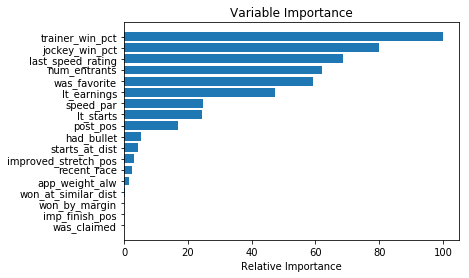

In [26]:
import matplotlib.pyplot as plt

#clf.fit(train_data, train_data)
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, dev_data.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Save Model to Disk

In [29]:
filename = 'win_gbc.joblib'
dump(clf, './models/{}'.format(filename)) 

['./models/win_gbc.joblib']